In [1]:
#import tensorflow as tf
#from tensorflow.python.client import device_lib
#tf.config.list_physical_devices('GPU')
#device_lib.list_local_devices()
#tf.test.is_built_with_cuda()

# Utilities

In [82]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential , Model , load_model
from tensorflow.keras.layers import Activation , Dense , Dropout ,Flatten , BatchNormalization , Conv2D , MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from tensorflow.keras.applications.vgg16 import VGG16
from glob import iglob
from collections import Counter
import os
import cv2 as cv
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action = "ignore" , category =FutureWarning)
%matplotlib inline
# Import OpenCV
import cv2

# Utility
import os
import numpy as np
import itertools
import random
from collections import Counter
from glob import iglob

# Ignore warning
import warnings
warnings.filterwarnings('ignore')

# Confusion Matrix & classification report
from sklearn.metrics import confusion_matrix, classification_report , recall_score , f1_score




# settings

In [20]:

IMAGE_SIZE = (224, 224)
INPUT_SHAPE = (224, 224, 3)

# Keras settings
TRAIN_BATCH_SIZE = 15
VAL_BATCH_SIZE = 12
EPOCHS = 50
LEARNING_RATE = 0.0001
total_training_samples = 192
training_batchSize = 16
total_validation_samples = 63
valid_batchSize = 8
#MODEL_PATH = os.path.join("skin diseases classification.h5")
#model_PATH2 = os.path.join("skin diseases classification2.h5")

# Data preparation

Organize data into train , valid , test dirs
Organize data into train, valid, test dirs
import os
os.chdir(r'C:\Dataset\normal-vs-monkeypox-vs-chickenpox')
if os.path.isdir('train/normal') is False:
    os.makedirs('train/noraml')
    os.makedirs('train/monkeypox')
    os.makedirs('train/chickenpox')
    os.makedirs('valid/normal')
    os.makedirs('valid/monkeypox')
    os.makedirs('valid/chickenpox')
    os.makedirs('test/normal')
    os.makedirs('test/monkeypox')
    os.makedirs('test/chickenpox')
    print(os.getcwd())

    for i in random.sample(glob.glob('normal*'), 180):   # train --> normal
        shutil.move(i, 'train/normal')
    for i in random.sample(glob.glob('monkeypox*'), 98):   #  train ---> monkeypox
        shutil.move(i, 'train/monkeypox')
    for i in random.sample(glob.glob('chickenpox*'), 106):   #  train ---> chickenpox
        shutil.move(i, 'train/chickenpox')
    for i in random.sample(glob.glob('normal*'), 33):   #   valid --->normal 
        shutil.move(i, 'valid/normal')
    for i in random.sample(glob.glob('monkeypox*'), 33):   # valid ---> monkeypox
        shutil.move(i, 'valid/monkeypox')
    for i in random.sample(glob.glob('chickenpox*'), 33):   # valid ---> chickenpox
        shutil.move(i, 'valid/chickenpox')
    for i in random.sample(glob.glob('normal*'), 33):  
        shutil.move(i, 'test/normal')
    for i in random.sample(glob.glob('monkeypox*'), 33):   #  test ---> monkeypox
        shutil.move(i, 'test/monkeypox')
    #for i in random.sample(glob.glob('chickenpox*'), 33):   #  test ---> chickenpox
        #shutil.move(i, 'test/chickenpox')
os.chdir('../../')

## We simply split our directory, which contains three folders named normal, monkeypox, and chickenpox, into train, valid, and test folders named splitted folders with a 60%, 20%, and 20% ratio, respectively.

In [4]:
# pip install split-folders

In [46]:
import splitfolders

In [47]:
input_folder = 'C:/Dataset/Data_split'
output_folder = 'C:/Dataset/splitted_images'

In [48]:
splitfolders.ratio(input_folder, output_folder,
    seed=42, ratio=(.6, .2, .2), group_prefix=None, move=False)



Copying files: 321 files [00:00, 1476.42 files/s]


# this function to display or plot dataset classes.

In [71]:
def percentage_value(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

def plot_dataset_description(path, title):
    classes = []
    for filename in iglob(os.path.join(path, "**","*.png")):
        classes.append(os.path.split(os.path.split(filename)[0])[-1])

    classes_cnt = Counter(classes)
    values = list(classes_cnt.values())
    labels = list(classes_cnt.keys())

    plt.figure(figsize=(8,8))
    plt.pie(values, labels=labels, autopct=lambda pct: percentage_value(pct, values), 
            shadow=True, startangle=140 , normalize=True)

    plt.title(title)    
    plt.show()

# organize our data 

In [21]:
base_dataset_folder = 'C:/Dataset/splitted_images'

In [22]:
train_folder = 'C:/Dataset/splitted_images/train'
valid_folder = 'C:/Dataset/splitted_images/val'
test_folder = 'C:/Dataset/splitted_images/test'

### Construct an instance of the ImageDataGenerator class
### Pass the augmentation parameters through the constructor. 
### here we do the data augmentation on the 'fly' as it augments the data image through the training model phase and identifies the batch size and epochs number as stop flag to stop generate more data(augment).

In [69]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest',
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range = 45,
        brightness_range =[0.3,0.9] ,
          )

train_generator = train_datagen.flow_from_directory(
        os.path.join(base_dataset_folder, train_folder),
        target_size=IMAGE_SIZE,
        batch_size=TRAIN_BATCH_SIZE,
        classes = ['normal','monkeypox','chickenpox'],
        class_mode='categorical', 
        #save_to_dir='augmented', 
       # save_prefix='aug', 
        #save_format= "png", 
        shuffle=True)

Found 279 images belonging to 3 classes.


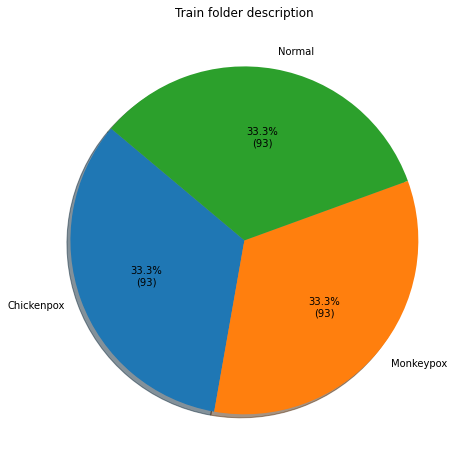

In [72]:
plot_dataset_description(os.path.join(base_dataset_folder, train_folder), "Train folder description")

In [54]:
val_datagen = ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(
        os.path.join(base_dataset_folder,valid_folder),
        target_size=IMAGE_SIZE,
        color_mode='rgb',
        classes = ['normal','monkeypox','chickenpox'],
        class_mode='categorical', 
        shuffle=False)

Found 120 images belonging to 3 classes.


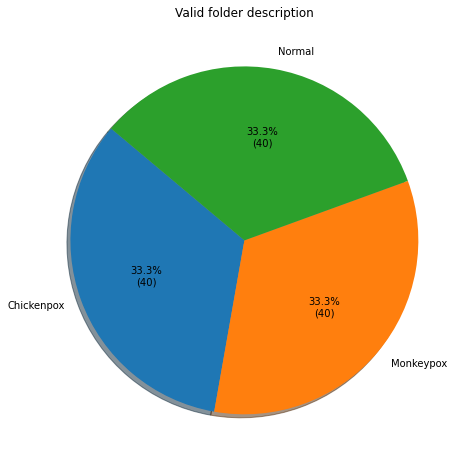

In [55]:
plot_dataset_description(os.path.join(base_dataset_folder, valid_folder), "Valid folder description")

In [23]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        os.path.join(base_dataset_folder, test_folder),
        target_size=IMAGE_SIZE,
        batch_size=VAL_BATCH_SIZE,
        class_mode='categorical', 
        shuffle=False)

Found 117 images belonging to 3 classes.


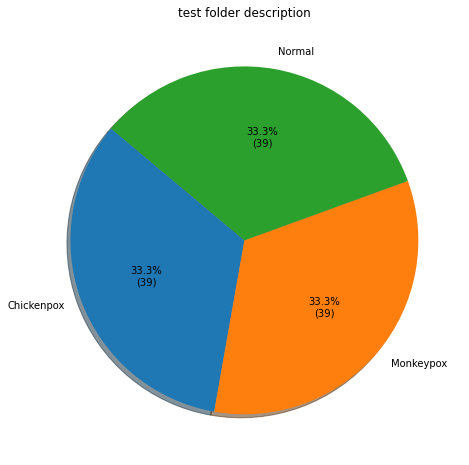

In [57]:
plot_dataset_description(os.path.join(base_dataset_folder, test_folder), "test folder description")

In [58]:
# notes
#train_generator.batch_size ----> 32
#steps = train_generator.samples//train_generator.batch_size ---> 6
#print(steps)

## key : value representation for 3 classes.
## 0 ---> key , 'normal' ----> value

In [73]:
classes = {value : key for key, value in train_generator.class_indices.items()}
print(classes)
# train_generator.class_indices

{0: 'normal', 1: 'monkeypox', 2: 'chickenpox'}


# As we using Transfer learning
### First : load the pre-trained VGG-16 model without the top layer ---> set false.

In [60]:
def create_model(input_shape , n_classes , optimizer = Adam(learning_rate = LEARNING_RATE)):
    conv_base = VGG16(include_top = False , weights = 'imagenet' , input_shape = input_shape)
### Freeze the layers except the last 4 layers
    for layer in conv_base.layers[:-4]:
        layer.trainable = False
    model = Sequential()
# Add the vgg convolutional base model
    model.add(conv_base)
 # Add new layers
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(n_classes, activation='softmax'))

    #model = Model(inputs = conv_base.input , outputs = output_layer)

    model.compile(optimizer = optimizer  , loss = 'categorical_crossentropy' , metrics =['accuracy'])
    return model

In [20]:
model = create_model(INPUT_SHAPE,len(classes))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 3

In [61]:
model2 = create_model(INPUT_SHAPE,len(classes))

In [62]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                

In [64]:

model_history = model2.fit_generator(train_generator,
    epochs=EPOCHS,
    steps_per_epoch=train_generator.samples//train_generator.batch_size,
    verbose=2,
    callbacks=None,
    validation_data= val_generator,
    validation_steps=val_generator.samples//val_generator.batch_size
    ) 

Epoch 1/50
18/18 - 38s - loss: 1.1650 - accuracy: 0.4167 - val_loss: 0.8013 - val_accuracy: 0.6354 - 38s/epoch - 2s/step
Epoch 2/50
18/18 - 41s - loss: 0.9950 - accuracy: 0.4924 - val_loss: 0.7759 - val_accuracy: 0.5938 - 41s/epoch - 2s/step
Epoch 3/50
18/18 - 40s - loss: 0.9427 - accuracy: 0.5114 - val_loss: 0.7003 - val_accuracy: 0.7500 - 40s/epoch - 2s/step
Epoch 4/50
18/18 - 40s - loss: 0.9035 - accuracy: 0.5455 - val_loss: 0.6164 - val_accuracy: 0.7917 - 40s/epoch - 2s/step
Epoch 5/50
18/18 - 40s - loss: 0.7813 - accuracy: 0.6894 - val_loss: 0.5977 - val_accuracy: 0.7708 - 40s/epoch - 2s/step
Epoch 6/50
18/18 - 40s - loss: 0.8758 - accuracy: 0.5871 - val_loss: 0.5171 - val_accuracy: 0.8333 - 40s/epoch - 2s/step
Epoch 7/50
18/18 - 42s - loss: 0.7940 - accuracy: 0.6174 - val_loss: 0.4612 - val_accuracy: 0.8750 - 42s/epoch - 2s/step
Epoch 8/50
18/18 - 42s - loss: 0.7229 - accuracy: 0.6818 - val_loss: 0.4249 - val_accuracy: 0.8438 - 42s/epoch - 2s/step
Epoch 9/50
18/18 - 41s - loss: 0

### steps_per_epoch = Total Training Samples / Training Batch Size
### validation_steps = Total validation Samples / Valid ationBatch Size

In [21]:
model_history = model.fit_generator(train_generator,
    epochs=EPOCHS,
    verbose=2,
    callbacks=None,
    validation_data= val_generator,
    ) 

Epoch 1/50
5/5 - 43s - loss: 1.2011 - accuracy: 0.3835 - val_loss: 0.9412 - val_accuracy: 0.6167 - 43s/epoch - 9s/step
Epoch 2/50
5/5 - 46s - loss: 1.0880 - accuracy: 0.4265 - val_loss: 0.9399 - val_accuracy: 0.5167 - 46s/epoch - 9s/step
Epoch 3/50
5/5 - 46s - loss: 1.0152 - accuracy: 0.4767 - val_loss: 0.8508 - val_accuracy: 0.6333 - 46s/epoch - 9s/step
Epoch 4/50
5/5 - 45s - loss: 0.9981 - accuracy: 0.4731 - val_loss: 0.8827 - val_accuracy: 0.6250 - 45s/epoch - 9s/step
Epoch 5/50
5/5 - 45s - loss: 0.9683 - accuracy: 0.5233 - val_loss: 1.0219 - val_accuracy: 0.5583 - 45s/epoch - 9s/step
Epoch 6/50
5/5 - 46s - loss: 0.9027 - accuracy: 0.5699 - val_loss: 0.7547 - val_accuracy: 0.6750 - 46s/epoch - 9s/step
Epoch 7/50
5/5 - 48s - loss: 0.8861 - accuracy: 0.5914 - val_loss: 0.8084 - val_accuracy: 0.6583 - 48s/epoch - 10s/step
Epoch 8/50
5/5 - 46s - loss: 0.8456 - accuracy: 0.6237 - val_loss: 0.6722 - val_accuracy: 0.7500 - 46s/epoch - 9s/step
Epoch 9/50
5/5 - 45s - loss: 0.8062 - accuracy:

In [23]:
model.save(MODEL_PATH)

In [81]:
model2.save(model_PATH2)

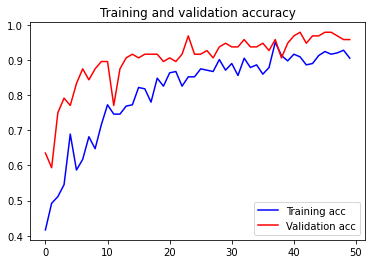

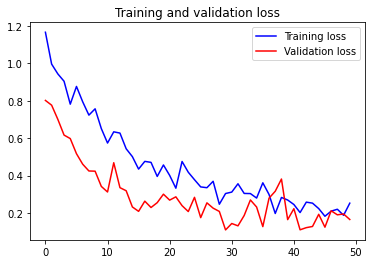

In [73]:
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

# load model1 , model2 and make prediction and testing 

In [3]:
model = load_model("skin diseases classification.h5")

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 3)                 3

In [14]:
model.get_weights()

[array([[[[ 4.29470569e-01,  1.17273867e-01,  3.40129584e-02, ...,
           -1.32241577e-01, -5.33475243e-02,  7.57738389e-03],
          [ 5.50379455e-01,  2.08774377e-02,  9.88311544e-02, ...,
           -8.48205537e-02, -5.11389151e-02,  3.74943428e-02],
          [ 4.80015397e-01, -1.72696680e-01,  3.75577137e-02, ...,
           -1.27135560e-01, -5.02991639e-02,  3.48965675e-02]],
 
         [[ 3.73466998e-01,  1.62062630e-01,  1.70863140e-03, ...,
           -1.48207128e-01, -2.35300660e-01, -6.30356818e-02],
          [ 4.40074533e-01,  4.73412387e-02,  5.13819456e-02, ...,
           -9.88498852e-02, -2.96195745e-01, -7.04357103e-02],
          [ 4.08547401e-01, -1.70375049e-01, -4.96297423e-03, ...,
           -1.22360572e-01, -2.76450396e-01, -3.90796512e-02]],
 
         [[-6.13601133e-02,  1.35693997e-01, -1.15694344e-01, ...,
           -1.40158370e-01, -3.77666801e-01, -3.00509870e-01],
          [-8.13870355e-02,  4.18543853e-02, -1.01763301e-01, ...,
           -9.431

In [15]:
model.optimizer

In [12]:
model2 = load_model("skin diseases classification2.h5")

In [13]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_3 (Dense)             (None, 256)               6422784   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 3)                

In [16]:
model2.get_weights()

[array([[[[ 4.29470569e-01,  1.17273867e-01,  3.40129584e-02, ...,
           -1.32241577e-01, -5.33475243e-02,  7.57738389e-03],
          [ 5.50379455e-01,  2.08774377e-02,  9.88311544e-02, ...,
           -8.48205537e-02, -5.11389151e-02,  3.74943428e-02],
          [ 4.80015397e-01, -1.72696680e-01,  3.75577137e-02, ...,
           -1.27135560e-01, -5.02991639e-02,  3.48965675e-02]],
 
         [[ 3.73466998e-01,  1.62062630e-01,  1.70863140e-03, ...,
           -1.48207128e-01, -2.35300660e-01, -6.30356818e-02],
          [ 4.40074533e-01,  4.73412387e-02,  5.13819456e-02, ...,
           -9.88498852e-02, -2.96195745e-01, -7.04357103e-02],
          [ 4.08547401e-01, -1.70375049e-01, -4.96297423e-03, ...,
           -1.22360572e-01, -2.76450396e-01, -3.90796512e-02]],
 
         [[-6.13601133e-02,  1.35693997e-01, -1.15694344e-01, ...,
           -1.40158370e-01, -3.77666801e-01, -3.00509870e-01],
          [-8.13870355e-02,  4.18543853e-02, -1.01763301e-01, ...,
           -9.431

In [36]:
loss, accuracy = model.evaluate_generator(test_generator,steps=test_generator.samples//test_generator.batch_size)

In [40]:
print("On testing data the loss and Accuracy respictively : ", loss , accuracy)

On testing data the loss and Accuracy respictively :  7.419200420379639 0.37037035822868347


In [41]:
loss, accuracy = model2.evaluate_generator(test_generator,steps=test_generator.samples//test_generator.batch_size)

In [42]:
print("On testing data the loss and Accuracy respictively : ", loss , accuracy)

On testing data the loss and Accuracy respictively :  10.145953178405762 0.3888888955116272


# confusion matrix

In [43]:
Y_pred = model.predict_generator(test_generator,verbose=1, steps=test_generator.samples//test_generator.batch_size)

9/9 [==============================] - 8s 880ms/step


In [45]:
y_pred = np.argmax(Y_pred, axis=1)

In [62]:
cnf_matrix = confusion_matrix(test_generator.classes[:108], y_pred)

<AxesSubplot:>

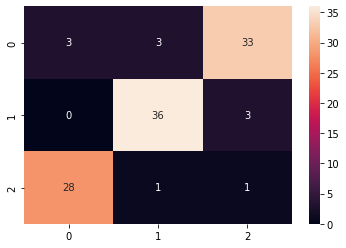

In [64]:
import seaborn as sns
sns.heatmap(cnf_matrix , annot = True)

In [65]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(12,12))

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=18)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45, fontsize=8)
    plt.yticks(tick_marks, classes, fontsize=12)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predicted label', fontsize=16)

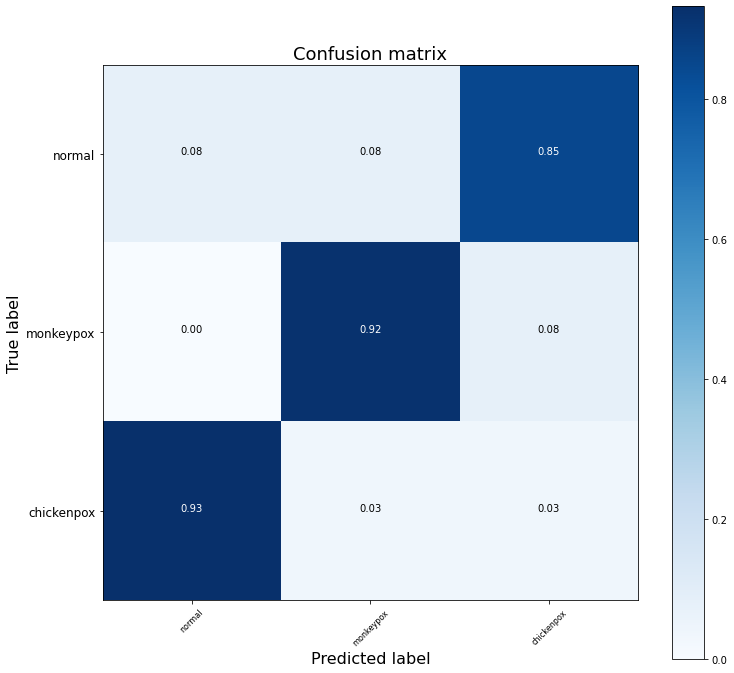

In [74]:

plot_confusion_matrix(cnf_matrix, list(classes.values()))

In [75]:
# test_generator.classes[:108] ----> y_true
print(classification_report(test_generator.classes[:108], y_pred))

              precision    recall  f1-score   support

           0       0.10      0.08      0.09        39
           1       0.90      0.92      0.91        39
           2       0.03      0.03      0.03        30

    accuracy                           0.37       108
   macro avg       0.34      0.34      0.34       108
weighted avg       0.37      0.37      0.37       108



In [79]:
def load_image(filename):
    img = cv.imread(os.path.join(base_dataset_folder, test_folder, filename))
    img = cv.resize(img, (IMAGE_SIZE[0], IMAGE_SIZE[1]) ) # (IMAGE_SIZE[0], IMAGE_SIZE[1]) ---> 224 ,224
    img = img /255        # we scale the input data for testing 
    
    return img


def predict(image):
    probabilities = model.predict(np.asarray([img]))[0]
    class_idx = np.argmax(probabilities)
    
    return {classes[class_idx]: probabilities[class_idx]}

SOURCE: class: Monkeypox, file: Monkeypox\monkeypox64.png
1/1 [==============================] - 0s 98ms/step
PREDICTED: class: monkeypox, confidence: 0.995130


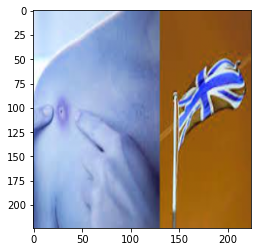

<Figure size 432x288 with 0 Axes>

SOURCE: class: Monkeypox, file: Monkeypox\monkeypox88.png
1/1 [==============================] - 0s 100ms/step
PREDICTED: class: monkeypox, confidence: 0.997449


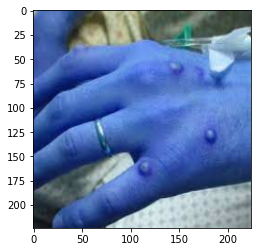

SOURCE: class: Chickenpox, file: Chickenpox\chickenpox74.png
1/1 [==============================] - 0s 99ms/step
PREDICTED: class: monkeypox, confidence: 0.935236


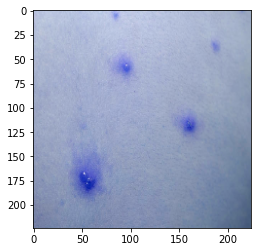

<Figure size 432x288 with 0 Axes>

SOURCE: class: Normal, file: Normal\normal69.png
1/1 [==============================] - 0s 100ms/step
PREDICTED: class: normal, confidence: 1.000000


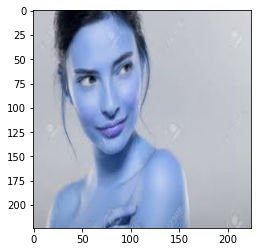

<Figure size 432x288 with 0 Axes>

SOURCE: class: Chickenpox, file: Chickenpox\chickenpox64.png
1/1 [==============================] - 0s 105ms/step
PREDICTED: class: chickenpox, confidence: 0.999864


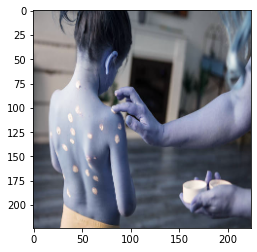

<Figure size 432x288 with 0 Axes>

SOURCE: class: Monkeypox, file: Monkeypox\monkeypox40.png
1/1 [==============================] - 0s 104ms/step
PREDICTED: class: monkeypox, confidence: 0.999069


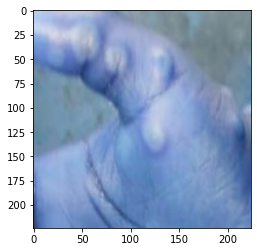

<Figure size 432x288 with 0 Axes>

SOURCE: class: Chickenpox, file: Chickenpox\chickenpox65.png
1/1 [==============================] - 0s 101ms/step
PREDICTED: class: chickenpox, confidence: 0.999258


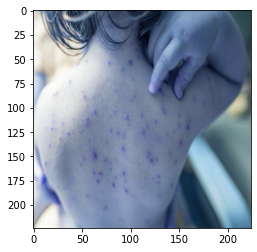

<Figure size 432x288 with 0 Axes>

SOURCE: class: Monkeypox, file: Monkeypox\monkeypox44.png
1/1 [==============================] - 0s 106ms/step
PREDICTED: class: monkeypox, confidence: 1.000000


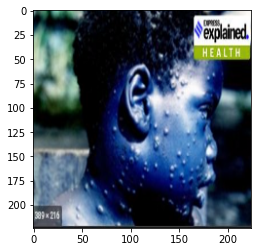

<Figure size 432x288 with 0 Axes>

SOURCE: class: Normal, file: Normal\normal28.png
1/1 [==============================] - 0s 95ms/step
PREDICTED: class: normal, confidence: 1.000000


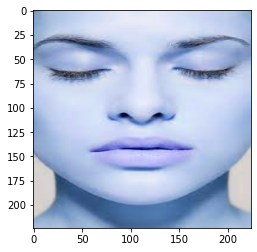

<Figure size 432x288 with 0 Axes>

SOURCE: class: Monkeypox, file: Monkeypox\monkeypox76.png
1/1 [==============================] - 0s 95ms/step
PREDICTED: class: monkeypox, confidence: 1.000000


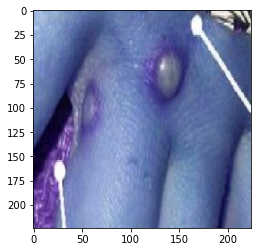

<Figure size 432x288 with 0 Axes>

In [81]:
for idx, filename in enumerate(random.sample(test_generator.filenames, 10)):
    print("SOURCE: class: %s, file: %s" % (os.path.split(filename)[0], filename))
    
    img = load_image(filename)
    prediction = predict(img)
    print("PREDICTED: class: %s, confidence: %f" % (list(prediction.keys())[0], list(prediction.values())[0]))
    plt.imshow(img)
    plt.figure(idx)    
    plt.show()